# Feature Engeneering for ride duration of taxi trips in New York City

In this notebook we explore feature extraction to build a model that predicts the total ride duration of taxi trips in New York City. We are using data from a Kaggle competition (https://www.kaggle.com/c/nyc-taxi-trip-duration/).

In [95]:
%matplotlib inline
import numpy as np 
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.cluster import MiniBatchKMeans
import warnings

In [96]:
plt.rcParams['figure.figsize'] = [13, 5]

## Initail data exploration

In [97]:
path = "/data/yinterian/nyc-taxi-trip-duration/"

In [218]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

In [219]:
train.shape

(1458644, 11)

In [220]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


Data Description
* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
* trip_duration - duration of the trip in seconds

In [221]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


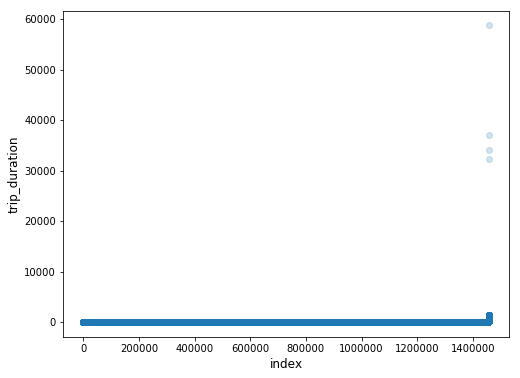

In [222]:
# let's look at the target variable
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train["trip_duration"].values/60), alpha=0.2)
plt.xlabel('index', fontsize=12)
plt.ylabel('trip_duration', fontsize=12)
plt.show()

In [223]:
# initial cleaning
train["trip_duration"].quantile([.0, 0.01, 0.25, .5, 0.75, 0.99, 1])

0.00          1.0
0.01         87.0
0.25        397.0
0.50        662.0
0.75       1075.0
0.99       3440.0
1.00    3526282.0
Name: trip_duration, dtype: float64

In [224]:
# The 99 quantile is 57. 3 minutes 
# getting rid of trips logger than one hour
deleted = train[train["trip_duration"] >= 60*60]
train = train[train["trip_duration"] < 60*60]
print(train.shape, deleted.shape)

(1446310, 11) (12334, 11)


In [225]:
# getting rid of trips shorter than one minute
train = train[train["trip_duration"] > 60]
print(train.shape)

(1437533, 11)


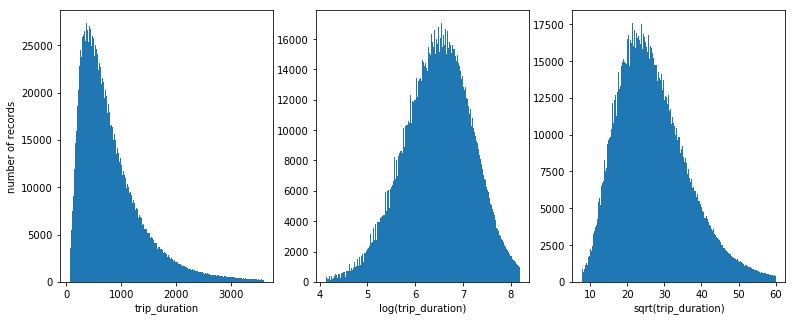

In [226]:
# It may be a good idea to transform the "y" variable
# Look for a transformation that give you a plot closer to a normal
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
train['sqrt_trip_duration'] = np.sqrt(train['trip_duration'].values)
fig, ax = plt.subplots(ncols=3, sharex=False, sharey=False)
ax[0].hist(train['trip_duration'].values, bins=200)
ax[1].hist(train['log_trip_duration'].values, bins=200)
ax[2].hist(train['sqrt_trip_duration'].values, bins=200)
ax[0].set_ylabel('number of records')
ax[0].set_xlabel('trip_duration')
ax[1].set_xlabel('log(trip_duration)')
ax[2].set_xlabel('sqrt(trip_duration)')
plt.show()

## Distance & Speed

In [227]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

In [228]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,sqrt_trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,21.330729
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,25.748786
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,46.086874
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,20.712315
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,20.856654


In [229]:
# this formulas accepts nump arrays
from math import radians, cos, sin, asin, sqrt

def L2_distance(lon1, lat1, lon2, lat2):
    """
    """
    dlon = (lon2 - lon1)**2 
    dlat = (lat2 - lat1)**2
    return 1000*np.sqrt(dlon + dlat)

In [230]:
def compute_distance(df):
    lon1 = df['pickup_longitude'].values
    lat1 = df['pickup_latitude'].values
    lon2 = df['dropoff_longitude'].values
    lat2 = df['dropoff_latitude'].values
    return L2_distance(lon1, lat1, lon2, lat2)

In [231]:
train['distance'] = compute_distance(train)
test['distance'] = compute_distance(test)

In [232]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,log_trip_duration,sqrt_trip_duration,distance
count,1.437533e+06,1.437533e+06,1.437533e+06,1.437533e+06,1.437533e+06,1.437533e+06,1.437533e+06,1.437533e+06,1.437533e+06,1.437533e+06
mean,1.534866e+00,1.664864e+00,-7.397428e+01,4.075131e+01,-7.397384e+01,4.075206e+01,8.164712e+02,6.467043e+00,2.696299e+01,3.453177e+01
std,4.987830e-01,1.314656e+00,6.997894e-02,3.208705e-02,6.993927e-02,3.521628e-02,5.833988e+02,7.126500e-01,9.458772e+00,4.354683e+01
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,6.100000e+01,4.127134e+00,7.810250e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399191e+01,4.073762e+01,-7.399133e+01,4.073617e+01,3.990000e+02,5.991465e+00,1.997498e+01,1.266764e+01
50%,2.000000e+00,1.000000e+00,-7.398182e+01,4.075424e+01,-7.397979e+01,4.075462e+01,6.610000e+02,6.495266e+00,2.570992e+01,2.119937e+01
75%,2.000000e+00,2.000000e+00,-7.396768e+01,4.076840e+01,-7.396322e+01,4.076989e+01,1.064000e+03,6.970730e+00,3.261901e+01,3.797385e+01
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.599000e+03,8.188689e+00,5.999167e+01,1.119260e+04


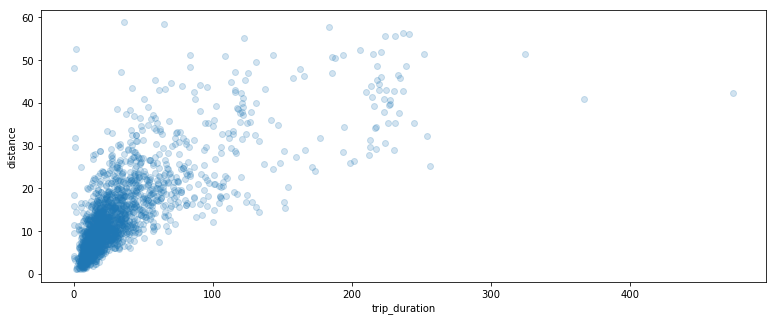

array([[ 1.        ,  0.74082196],
       [ 0.74082196,  1.        ]])

In [233]:
y = train['trip_duration'][:2000]/60
x = train['distance'][:2000]
plt.scatter(x, y, alpha=0.2)
plt.xlabel('trip_duration')
plt.ylabel('distance')
plt.show()
np.corrcoef(x,y)

In [234]:
# ?miles an hour
train["speed"] = train["distance"]/ (train["trip_duration"] / 360.0)

Note that 'speed' is not a feature since it needs trip duration which is the target variable.
We are using it just as part of our exploration

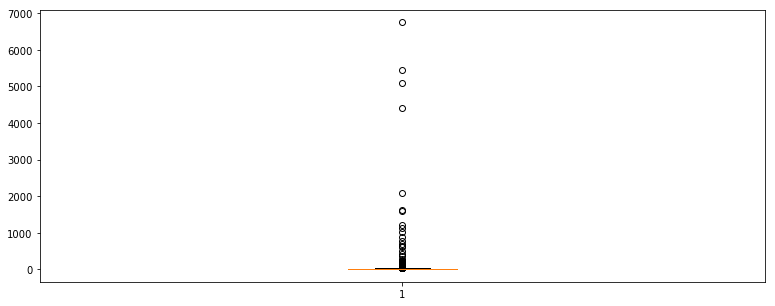

In [235]:
plt.boxplot(train['speed'])
plt.show()

In [236]:
# some more cleaning here
train['speed'].quantile([.0, 0.25, .5, 0.75, 0.999, 1])

0.000       0.000000
0.250       9.314723
0.500      12.944786
0.750      17.937170
0.999      55.765426
1.000    6749.747037
Name: speed, dtype: float64

In [237]:
train = train[train['speed'] < 60]

In [238]:
train.shape

(1436884, 15)

## Time features

We will define some time features. By plotting every feature agains the "trip_duration" or "speed" we will be able to see if there is any useful correlations. 

In [239]:
def get_time_features(df):
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
    df['pickup_weekofyear'] = df['pickup_datetime'].dt.weekofyear
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']
    return df

In [240]:
train = get_time_features(train)
test = get_time_features(test)

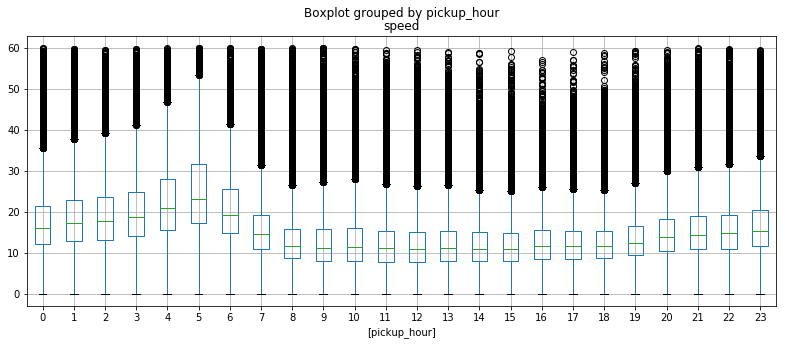

In [241]:
metric = 'pickup_hour'
y = 'speed'
train.boxplot(column=y, by=[metric])

Looks like speed is lower in the middle of the day which makes pickup hour a likely useful feature.

Plot other features. Do they seem useful?

## Clustering based on lat and long

In [242]:
places = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

In [243]:
places.shape

(2873768, 2)

In [244]:
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(places)

In [245]:
# here the new features is the id of the cluster
train['pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train['dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test['pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test['dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

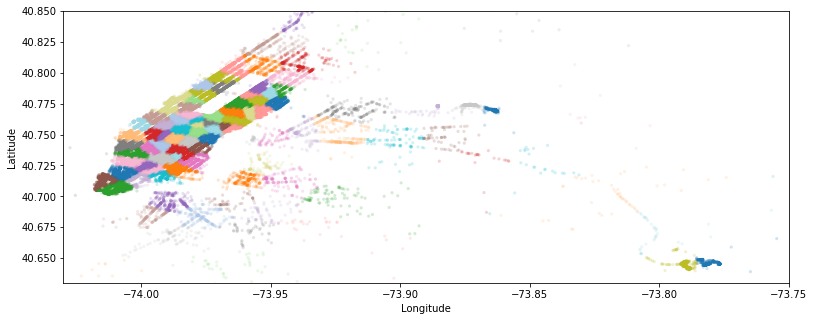

In [246]:
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
#There are some weird outliers here

## Split train and validation

In [247]:
# split train and validation
np.random.seed(3)
n = train.shape[0]
inx = np.random.permutation(n)
n_sample = int(0.8*n)
train_set = train[train.index.isin(inx[:n_sample])]
val_set = train[~train.index.isin(inx[:n_sample])]
print(train_set.shape, val_set.shape)

(1132432, 21) (304452, 21)


## Target Encoding

Here is an example of what is called 'Target Encoding'. The idea here is given a categorical variable, create a new variable that is the mean each categorical value variable in the training data. 

Note that I divided the train and validation sets before doing this. Since the computation of these involve the target variable, we do it in the training and transfer it to the test/ validation sets.

In [248]:
col = 'pickup_weekday'
gby = train_set.groupby(col).mean()[['speed', 'log_trip_duration']]
gby.columns = ['%s_gby_%s' % (c, col) for c in gby.columns]
gby

,speed_gby_pickup_weekday,log_trip_duration_gby_pickup_weekday
pickup_weekday,,
0,15.339333,6.428681
1,13.943331,6.491490
2,13.678195,6.510132
3,13.633336,6.525696
4,13.956837,6.494949
5,15.100131,6.425129
6,16.934209,6.384738


In [249]:
for col in ['pickup_weekday', 'pickup_weekofyear', 'pickup_hour',
       'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    gby = train_set.groupby(col).mean()[['speed', 'log_trip_duration']]
    gby.columns = ['%s_gby_%s' % (c, col) for c in gby.columns]
    train_set = pd.merge(train_set, gby, how='left', left_on=col, right_index=True)
    val_set = pd.merge(val_set, gby, how='left', left_on=col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=col, right_index=True)

In [250]:
train_set.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,speed_gby_pickup_weekofyear,log_trip_duration_gby_pickup_weekofyear,speed_gby_pickup_hour,log_trip_duration_gby_pickup_hour,speed_gby_pickup_week_hour,log_trip_duration_gby_pickup_week_hour,speed_gby_pickup_cluster,log_trip_duration_gby_pickup_cluster,speed_gby_dropoff_cluster,log_trip_duration_gby_dropoff_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,14.665374,6.457115,12.609901,6.520541,13.201231,6.457985,12.764217,6.491518,12.595947,6.259639
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,14.559002,6.422254,12.628164,6.522402,10.902781,6.643997,12.764217,6.491518,16.628846,6.731731
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,14.277489,6.470075,13.751587,6.447591,13.211405,6.462718,14.392842,6.536059,16.628846,6.731731
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,15.238559,6.439426,12.641380,6.535755,13.559827,6.443439,16.247347,6.252422,14.847202,6.267357
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,...,14.496447,6.496825,16.214178,6.472372,14.712484,6.514195,15.733389,6.340293,14.677224,6.268141


In [251]:
# More 'target encoding' and 'count encoding'
for cols in [['pickup_hour', 'pickup_cluster'],
                 ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    speed = train_set.groupby(cols).mean()[['speed']].reset_index()
    count = train.groupby(cols).count()[['id']].reset_index()
    stats = pd.merge(speed, count, on=cols)
    stats = stats[stats['id'] > 100]
    stats.columns = cols + ['speed_%s' % '_'.join(cols), 'cnt_%s' %  '_'.join(cols)]
    train_set = pd.merge(train_set, stats, how='left', on=cols)
    val_set = pd.merge(val_set, stats, how='left', on=cols)
    test = pd.merge(test, stats, how='left', on=cols)

In [263]:
# where are the NAs
df_na = train_set.isnull().any()
[fea for fea in df_na.index if df_na[fea]]

['speed_pickup_hour_pickup_cluster',
 'cnt_pickup_hour_pickup_cluster',
 'speed_pickup_hour_dropoff_cluster',
 'cnt_pickup_hour_dropoff_cluster']

In [265]:
# fix NAs
for col in  ['speed_pickup_cluster_dropoff_cluster', 'speed_pickup_hour_pickup_cluster',
             'speed_pickup_hour_dropoff_cluster']:
    m = train_set[col].mean()
    print(col, m)
    train_set[col].fillna(m, inplace=True)
    val_set[col].fillna(m, inplace=True)
    test[col].fillna(m, inplace=True)

speed_pickup_cluster_dropoff_cluster 13.908124819806227
speed_pickup_hour_pickup_cluster 14.533808291181892
speed_pickup_hour_dropoff_cluster 14.479590424782996


In [266]:
for col in ['cnt_pickup_cluster_dropoff_cluster', 'cnt_pickup_hour_pickup_cluster', 
            'cnt_pickup_hour_dropoff_cluster']:
    m = 0
    train_set[col].fillna(m, inplace=True)
    val_set[col].fillna(m, inplace=True)
    test[col].fillna(m, inplace=True)

## Initial model

In [267]:
train_set.columns.shape

(39,)

In [268]:
ind = [4, 5, 6, 7, 8, 13] + list(range(15, 39))
features = train_set.columns[ind]
features

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance', 'pickup_weekday',
       'pickup_weekofyear', 'pickup_hour', 'pickup_week_hour',
       'pickup_cluster', 'dropoff_cluster', 'speed_gby_pickup_weekday',
       'log_trip_duration_gby_pickup_weekday', 'speed_gby_pickup_weekofyear',
       'log_trip_duration_gby_pickup_weekofyear', 'speed_gby_pickup_hour',
       'log_trip_duration_gby_pickup_hour', 'speed_gby_pickup_week_hour',
       'log_trip_duration_gby_pickup_week_hour', 'speed_gby_pickup_cluster',
       'log_trip_duration_gby_pickup_cluster', 'speed_gby_dropoff_cluster',
       'log_trip_duration_gby_dropoff_cluster',
       'speed_pickup_hour_pickup_cluster', 'cnt_pickup_hour_pickup_cluster',
       'speed_pickup_hour_dropoff_cluster', 'cnt_pickup_hour_dropoff_cluster',
       'speed_pickup_cluster_dropoff_cluster',
       'cnt_pickup_cluster_dropoff_cluster'],
      dtype='object')

In [269]:
train_set.shape

(1132432, 39)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
t0 = dt.datetime.now()
rf = RandomForestRegressor(n_estimators=100, n_jobs=2)
train_y = train_set['log_trip_duration'].values
rf.fit(train_set[features], train_y)
t1 = dt.datetime.now()
print('Time fitting random forest: %i seconds' % (t1 - t0).seconds)

In [182]:
predictions = rf.predict(val_set[features])

In [186]:
val_y = val_set['trip_duration'].values
pred = np.exp(predictions) -1 
res = pd.DataFrame({'pred': pred, 'y': val_y})
res.head(10)

,pred,y
0,662.538632,663
1,442.739010,443
2,1113.754584,1114
3,1316.124529,1317
4,423.179417,423
5,2485.303416,2485
6,695.227533,694
7,890.407317,892
8,1020.957709,1022
9,706.687912,707


In [187]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(val_y,pred))

29.380269999999999

In [147]:
test_predictions = rf.predict(test[features])

### Feature importance

In [86]:
importance = rf.feature_importances_
importance = pd.DataFrame(importance, index=features,
                          columns=["Importance"])
imp = importance.sort_values('Importance', ascending=False)
imp

,Importance
distance,0.665732
speed_gby_pickup_week_hour,0.062768
dropoff_latitude,0.035300
pickup_longitude,0.027528
dropoff_longitude,0.027455
pickup_latitude,0.026154
speed_gby_dropoff_cluster,0.024097
log_trip_duration_gby_pickup_week_hour,0.016220
log_trip_duration_gby_pickup_weekofyear,0.012586
speed_gby_pickup_weekofyear,0.012106


I have not been able to get this to work

In [ ]:
# here is the list of parameters
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
xgb_pars = {'eta': 0.1,
            'subsample': 0.5, 'lambda': 1.,  'silent': 0,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [ ]:
# initially training on a subset of the data
train_set = train_set[:500000]
train_set.shape

train_X = train_set[features].as_matrix()
val_X = val_set[features].as_matrix()
train_y = train_set['log_trip_duration'].values
val_y = val_set['log_trip_duration'].values

In [ ]:
# train xgboost model
t0 = dt.datetime.now()
gbm = xgb.XGBClassifier(n_estimators=10, learning_rate=0.1, max_depth=3, subsample=0.5)
gbm.fit(train_X, train_y)
t1 = dt.datetime.now()
print('Time fitting xgb: %i seconds' % (t1 - t0).seconds)

In [ ]:
predictions = gbm.predict(val_X)

## Features from external data

https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm
you can get this data with wget

wget https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm/downloads/fastest_routes_train_part_1.csv

## References

* https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367
* https://www.slideshare.net/HJvanVeen/feature-engineering-72376750?trk=v-feed